In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


In [2]:
# obj_steph <- readRDS('/data/srlab2/ik936/Roche/data/cache/stephenson_obj.rds')
# bulk_steph <- readRDS('/data/srlab2/ik936/Roche/data/cache/stephenson_bulk.rds')
# smillie_bulk <- readRDS('/data/srlab2/ik936/Roche/data/cache/smillie_bulk_fib.rds')
# smillie_effects <- readRDS('/data/srlab2/ik936/Roche/data/cache/smillie_effects.rds')
# smillie_meta <- readRDS('/data/srlab2/ik936/Roche/data/cache/smillie_metadata.rds')


In [3]:
# modules_df <- readRDS('/data/srlab2/ik936/Roche/data/cache/modules6_df.rds')
# modules_assoc <- openxlsx::read.xlsx('/data/srlab2/ik936/Roche/data/Fiona_Modules_Associations.xlsx', 3) %>% 
#     dplyr::select(moduleName = X1, matches('^Macroscopic|^Nancy')) 

# modules_assoc <- rbind(
#     dplyr::select(
#         modules_assoc, 
#         moduleName,
#         r = Macroscopic.inflammation_Cor,
#         p = Macroscopic.inflammation_Pvalue,
#         fdr = Macroscopic.inflammation_Pvalue_FDR_Pvalue
#     ) %>% 
#         dplyr::mutate(Type = 'Mascroscopic Inflammation'),
#     dplyr::select(
#         modules_assoc, 
#         moduleName,
#         r = Nancy_index_Cor,
#         p = Nancy_index_Pvalue,
#         fdr = Nancy_index_Pvalue_FDR_Pvalue    
#     ) %>% 
#         dplyr::mutate(Type = 'Nancy Index')

# )


In [4]:
meta_data <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds')
# scores_df <- readRDS('/data/srlab2/ik936/Roche/data/cache/inflam_scores_icdf.rds')
# meta_data <- meta_data %>% 
#     left_join(scores_df) 

meta_data <- meta_data %>% 
    dplyr::select(LibraryID, SampleID, Tissue, DonorID, Case, Diagnosis, matches('^Inflam|^percent_cd45')) %>% 
    unique()


In the lung, let's not distinguish early and late disease. 

In [5]:
case_levels <- c('Sicca', 'pSS', 'GutControl', 'GutNonisnflamed', 'GutInflamed', 'LungControl', 'End-stage IPF/RA-ILD', 'Early-stage ILD', 'Osteoarthritis', 'RheumatoidArthritis')
meta_data <- meta_data %>% 
    dplyr::mutate(
        Case = case_when(
#             Tissue == 'Lung' & Case != 'LungControl' ~ 'Lung Disease',
            Case == 'LungEarlyStageILD' ~ 'Early-stage ILD',
            Case == 'LungEndStageILD' ~ 'End-stage IPF/RA-ILD',
            Case == 'SICCA' ~ 'Sicca', 
            Case == 'PSS' ~ 'pSS',
            TRUE ~ Case
        )
    ) %>% 
    dplyr::mutate(Case = factor(Case, case_levels))

Tissue levels should match the order in which we discuss tissues in manuscript. 

In [6]:
meta_data <- meta_data %>% 
    dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut')))


In [7]:
head(meta_data)

,LibraryID,SampleID,Tissue,DonorID,Case,Diagnosis,InflamScore,InflamScore_raw,percent_cd45,percent_cd45_rescaled,percent_cd45_betaU,percent_cd45_beta3
,<chr>,<chr>,<fct>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GX44,GX44,SalivaryGland,GX44,Sicca,NA,0.3297227,0.1598264,23.95422,0.2226372,0.15132259,0.3813335
474,GX46,GX46,SalivaryGland,GX46,Sicca,NA,0.2120449,0.1181924,23.11703,0.2102460,0.07635821,0.3362964
991,GX47,GX47,SalivaryGland,GX47,pSS,NA,0.3284522,0.1593769,41.73158,0.4857593,0.62959633,0.5382441
1636,GX48,GX48,SalivaryGland,GX48,pSS,NA,0.8244676,0.3348654,71.89757,0.9322455,0.97168966,0.7157665
1821,GX50,GX50,SalivaryGland,GX50,pSS,NA,0.4933110,0.2177033,76.47528,1.0000000,0.99494461,0.7834405
2018,GX09,GX09,SalivaryGland,GX09,Sicca,NA,0.7920763,0.3234055,49.42400,0.5996146,0.74874506,0.5774190


In [8]:
dname <- '/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/'
fields_load <- c('gsea', 'masc', 'masc_meta', 'effects_marginal', 'meta_data', 'masc_raw')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


In [9]:
obj$masc_meta <- obj$masc_meta %>% 
    dplyr::left_join(unique(dplyr::select(obj$meta_data, Cluster, Cluster_name))) 

obj$masc <- obj$masc %>% 
    dplyr::left_join(unique(dplyr::select(obj$meta_data, Cluster, Cluster_name))) 


Joining, by = "Cluster"

Joining, by = "Cluster"



# Raw scores per tissue

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


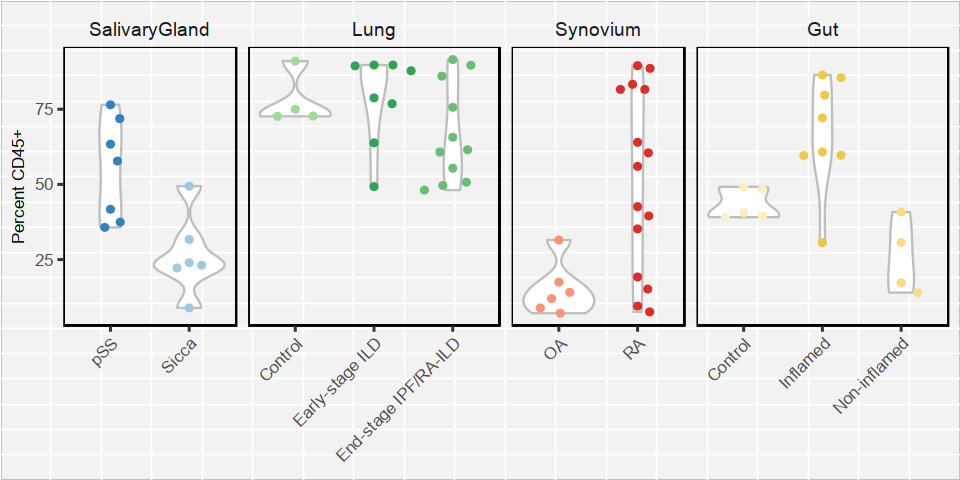

In [10]:
fig.size(4, 8)
f1 <- meta_data %>% 
    dplyr::mutate(Case_nice = case_when(
        Case == 'Osteoarthritis' ~ 'OA',
        Case == 'RheumatoidArthritis' ~ 'RA',
        Case == 'Lung Disease' ~ 'ILD',
        Case == 'LungControl' ~ 'Control',
        Case == 'GutNonisnflamed' ~ 'Non-inflamed',
        TRUE ~ gsub('Gut', '', Case)
    )) %>% 
#     split(.$Tissue) %>% 
#     imap(function(.SD, .tissue) {
        ggplot(aes(Case_nice, percent_cd45, color = Case)) + 
#         ggplot(.SD, aes(Case_nice, percent_cd45, color = Case)) + 
#         ggplot(.SD, aes(Case_nice, InflamScore_raw, color = Case)) + 
            geom_violin(color = 'grey') + 
            geom_beeswarm(cex = 8, priority = 'descending') + 
#             facet_wrap(~Tissue, nrow = 1, scales = 'free') + 
            guides(color = FALSE) + 
            labs(
                y = 'Percent CD45+'
#                 y = y_titles[[.tissue]],
#                 title = .tissue
    #             title = 'Unnormalized Scores'
            ) + 
            theme(
                axis.title.x = element_blank(),
#                 axis.text.x = element_blank(),
#                 axis.ticks.x = element_blank(),
                axis.text.x = element_text(angle = 45, hjust = 1),
                plot.title = element_text(size = 12),
                axis.title.y = element_text(size = 10)  
            ) + 
            facet_grid(~Tissue, scales = 'free', space = 'free')  + 
            NULL
#     })

# Reduce(`|`, f3)
f1 <- remove_strip_box(f1)
plot(f1)

# Normalized scores per tissue

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


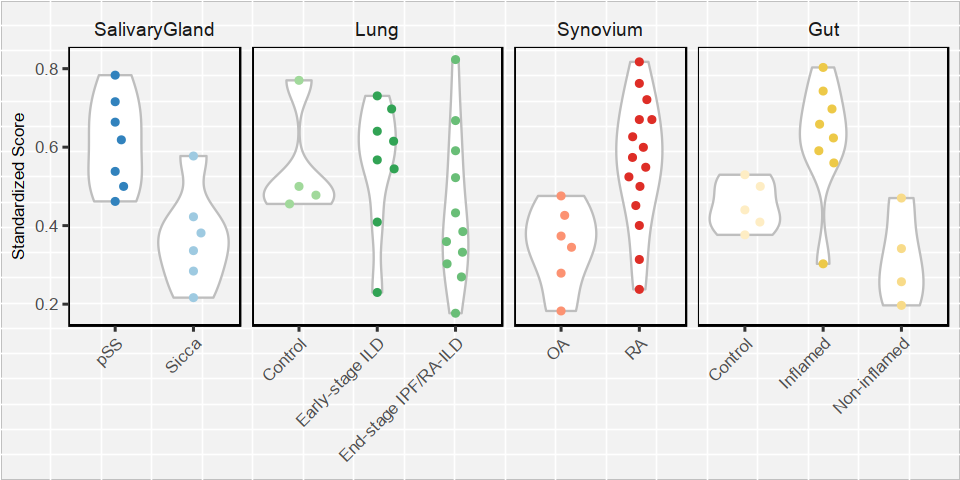

In [11]:
fig.size(4, 8)
f2 <- meta_data %>% 
    dplyr::mutate(Case_nice = case_when(
        Case == 'Osteoarthritis' ~ 'OA',
        Case == 'RheumatoidArthritis' ~ 'RA',
        Case == 'Lung Disease' ~ 'ILD',
        Case == 'LungControl' ~ 'Control',
        Case == 'GutNonisnflamed' ~ 'Non-inflamed',
        TRUE ~ gsub('Gut', '', Case)
    )) %>% 
#     split(.$Tissue) %>% 
#     imap(function(.SD, .tissue) {
        ggplot(aes(Case_nice, percent_cd45_beta3, color = Case)) + 
#         ggplot(.SD, aes(Case_nice, percent_cd45, color = Case)) + 
#         ggplot(.SD, aes(Case_nice, InflamScore_raw, color = Case)) + 
            geom_violin(color = 'grey') + 
            geom_beeswarm(cex = 8, priority = 'descending') + 
#             facet_wrap(~Tissue, nrow = 1, scales = 'free') + 
            guides(color = FALSE) + 
            labs(
                y = 'Standardized Score'
#                 y = y_titles[[.tissue]],
#                 title = .tissue
    #             title = 'Unnormalized Scores'
            ) + 
            theme(
                axis.title.x = element_blank(),
#                 axis.text.x = element_blank(),
#                 axis.ticks.x = element_blank(),
                axis.text.x = element_text(angle = 45, hjust = 1),
                plot.title = element_text(size = 12),
                axis.title.y = element_text(size = 10)  
            ) + 
            facet_grid(~Tissue, scales = 'free', space = 'free')  + 
            NULL
#     })

# Reduce(`|`, f3)
f2 <- remove_strip_box(f2)
plot(f2)


In [12]:
# fig.size(4, 5)
# f4 <- meta_data %>% 
#     ggplot(aes(Tissue, percent_cd45_beta3, color = Case)) + 
# #     ggplot(aes(Tissue, InflamScore_beta, color = Case)) + 
#         geom_violin(color = 'grey') + 
#         geom_beeswarm(cex = 8, priority = 'descending') + 
#         facet_wrap(~Tissue, nrow = 1, scales = 'free_x') + 
#         guides(color = FALSE) + 
#         labs(
#             y = 'Normalized Inflammation Score'
# #             title = 'Normalized Scores'
#         ) + 
#         theme(
#             axis.title.x = element_blank(),
#             axis.text.x = element_blank(),
#             axis.ticks.x = element_blank(),
# #             plot.title = element_text(size = 12),
#             axis.title.y = element_text(size = 12)  
#         ) + 
#         NULL

# f4


# MASC all tissue

In [13]:
masc_cluster_levels <- obj$masc_meta %>% arrange(beta_re) %>% with(Cluster_name)
fdr_max <- .1


Option to order clusters within tissue. 

In [14]:
# fig.size(5, 6)
# data.table(obj$masc)[, fdr := p.adjust(pvalue, 'BH')][] %>% 
# # data.table(obj$masc)[, fdr := p.adjust(pvalue, 'BH'), by = Tissue][] %>% 
#     dplyr::mutate(Cluster = paste0('C', Cluster)) %>% 
#     subset(sigma < 4) %>% 
# #     dplyr::mutate(Cluster = factor(Cluster, cluster_levels)) %>% 
#     ggplot(aes(reorder_within(Cluster, beta, Tissue), beta, color = fdr < fdr_max & beta > 0)) +     
#         geom_point() + 
#         geom_errorbar(aes(ymin = beta - 1.96 * sigma, ymax = beta + 1.96 * sigma), width = 0) + 
#         coord_flip() + 
#         scale_color_manual(values = c('black', 'red')) + 
#         geom_hline(yintercept = c(0), linetype = 2) + 
#         labs(x = '', y = 'Log2 fold change') + 
#         guides(color = FALSE) + 
#         facet_wrap(~Tissue, scales = 'free', nrow = 1) + 
#         scale_x_reordered() +
#         NULL    


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


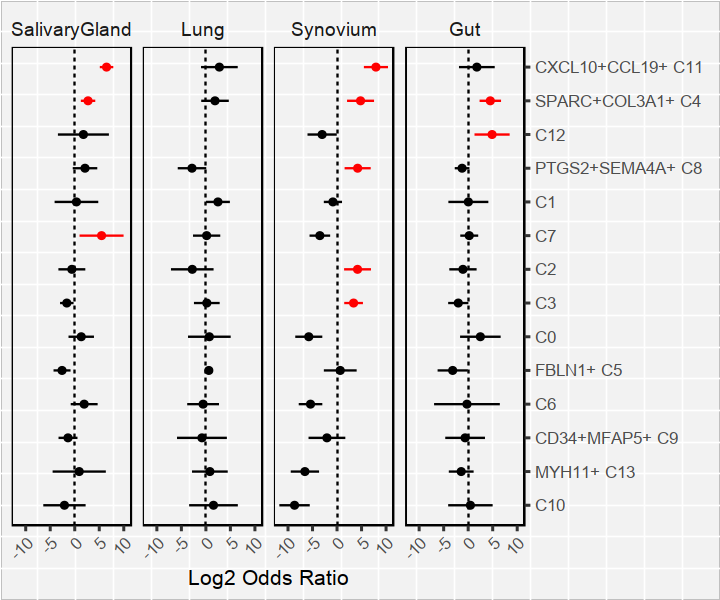

In [15]:
fig.size(5, 6)
f3 <- data.table(obj$masc)[, fdr := p.adjust(pvalue, 'BH')][] %>% 
    dplyr::select(Cluster = Cluster_name, Tissue, beta, sigma, fdr) %>% 
#     dplyr::mutate(Cluster = paste0('C', Cluster)) %>% 
    subset(sigma < 4) %>% 
#     ggplot(aes(reorder(Cluster, beta), beta, color = fdr < fdr_max & beta > 0)) +     
    dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))) %>% 
    dplyr::mutate(Cluster = factor(Cluster, masc_cluster_levels)) %>% 
    ggplot(aes(Cluster, beta, color = fdr < fdr_max & beta > 1)) +     
        geom_point() + 
        geom_errorbar(aes(ymin = beta - 1.96 * sigma, ymax = beta + 1.96 * sigma), width = 0) + 
        coord_flip() + 
        scale_color_manual(values = c('black', 'red')) + 
        geom_hline(yintercept = c(0), linetype = 2) + 
        labs(
#             x = '', 
            y = 'Log2 Odds Ratio'
#             title = 'Cluster abundance vs Inflammation association'
        ) + 
        guides(color = FALSE) + 
        facet_wrap(~Tissue, nrow = 1) + 
        theme(
#             plot.title = element_text(size = 12),
            axis.text.x = element_text(angle = 45, hjust = 1),
            axis.title.y = element_blank()
        ) + 
        scale_x_discrete(position = 'top') + 
        NULL    

f3 <- remove_strip_box(f3)
plot(f3)


# MASC meta 

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


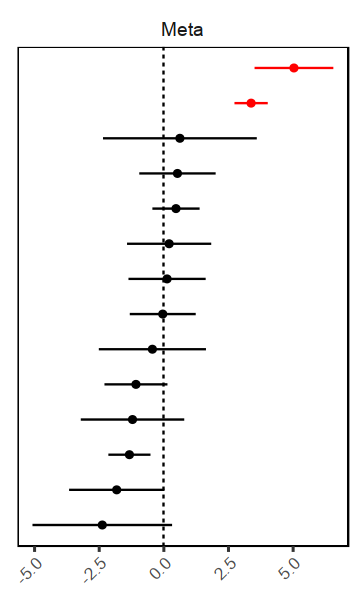

In [16]:
fig.size(5, 3)
f4 <- obj$masc_meta %>% 
    dplyr::select(Cluster = Cluster_name, beta = beta_re, sigma = sigma_re, fdr = fdr_re) %>% 
    dplyr::mutate(Cluster = factor(Cluster, masc_cluster_levels)) %>% 
    dplyr::mutate(Type = 'Meta') %>% 
    forest_uni(beta_min = 0) + 
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1), 
        axis.title = element_blank()
    ) + 
    facet_wrap(~Type) + 
#     labs(title = 'Meta-analysis')
    NULL

f4


# Scatter

In [17]:
fig.size(3, 5)

plt_df <- with(obj$meta_data, prop.table(table(LibraryID, Cluster_name), 1)) %>% 
    data.table() %>% 
    subset(N > 0 & grepl('C4|C11', Cluster_name)) %>% 
    left_join(meta_data) %>% 
    left_join(obj$masc) 

head(plt_df$r2_label)

Joining, by = "LibraryID"

Joining, by = c("Cluster_name", "Tissue")



NULL

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Ignoring unknown parameters: xmin”


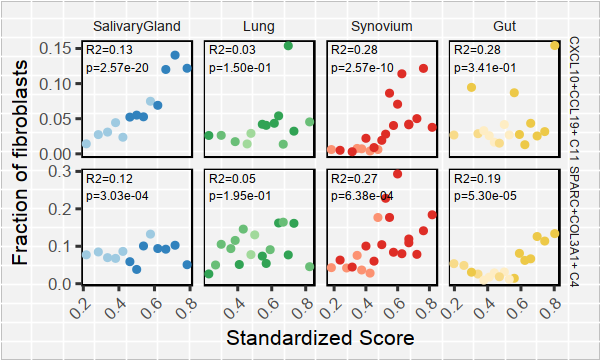

In [18]:
f5 <- ggplot(plt_df, aes(percent_cd45_beta3, N, color = Case)) + 
#         geom_smooth(method = 'lm', color = 'black', se = FALSE) + 
        geom_point() + 
        facet_grid(Cluster_name ~ Tissue, scales = 'free') + 
#         facet_grid(Cluster_name ~ Tissue, scales = 'free', switch = 'y') + 
        labs(x = 'Standardized Score', y = 'Fraction of fibroblasts') + 
        guides(color = FALSE) + 
        theme(
            axis.text.x = element_text(angle = 45, hjust = 1), 
            strip.text.y = element_text(size = 7),
            strip.text.x = element_text(size = 8)
        ) + 
        geom_text(
            data = data.table(plt_df)[, head(.SD[order(percent_cd45_beta3)], 1), by = .(Tissue, Cluster_name)], 
            aes(label = sprintf('R2=%0.2f\np=%0.2e', r2, pvalue)), size = 2.5, color = 'black',
            xmin = -Inf, y = Inf, vjust = 1.2, hjust = 0
        ) + 
        NULL

f5 <- remove_strip_box(f5)
plot(f5)

# C4 vs C11 genes - scatter 

In [19]:
genes_plot <- obj$effects_marginal %>% 
    subset(Cluster %in% c('4', '11')) %>% 
    split(.$Cluster) %>% 
    map(arrange, -zscore) %>% 
    map(head, 10) %>% 
    bind_rows() %>%
    with(unique(feature))


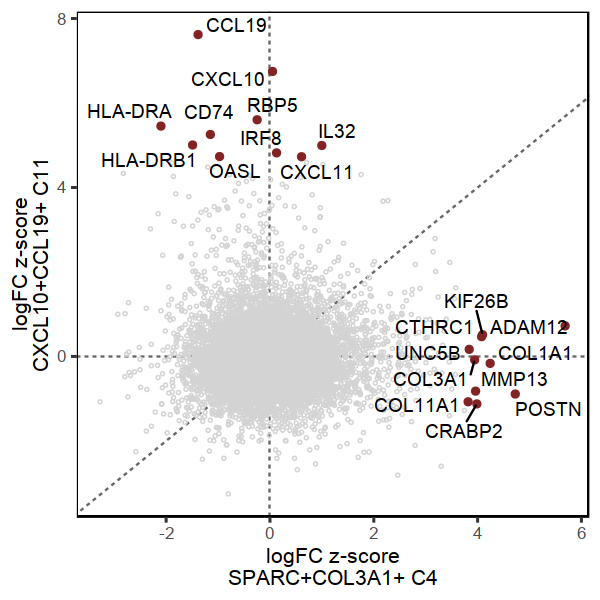

In [20]:
fig.size(5, 5)
f6 <- obj$effects_marginal %>% 
    subset(Cluster %in% c('4', '11')) %>% 
    dplyr::select(Cluster, feature, zscore) %>% 
    tidyr::spread(Cluster, zscore, fill = 0) %>% 
    ggplot(aes(`4`, `11`)) + 
        geom_abline(linetype = 2, alpha = .6) + 
        geom_vline(xintercept = 0, linetype = 2, alpha = .6) + 
        geom_hline(yintercept = 0, linetype = 2, alpha = .6) + 
        geom_point(shape = 21, size = .5, color = 'lightgrey') + 
        geom_point(
            data = . %>% subset(feature %in% genes_plot), 
            shape = 16, size = 2, color = muted('red')
        ) + 
        geom_text_repel(
            data = . %>% subset(feature %in% genes_plot),
            aes(label = feature)
        ) + 
        labs(x = 'logFC z-score\nSPARC+COL3A1+ C4', y = 'logFC z-score\nCXCL10+CCL19+ C11') + 
        NULL
f6


# Pathways

In [21]:
pathway_df <- list(
    tibble(
        pathway = c(
            'GO_EXTRACELLULAR_MATRIX_DISASSEMBLY', 
            'GO_EXTRACELLULAR_MATRIX_BINDING', 
#             'HALLMARK_ANGIOGENESIS', 
            'GO_ENDODERM_DEVELOPMENT', 
            'GO_BONE_DEVELOPMENT', 
            'GO_AORTA_DEVELOPMENT',
            'GO_CONNECTIVE_TISSUE_DEVELOPMENT'    
        ), 
        Label = 'Gene Ontology (C4)'
    ) %>% 
        dplyr::mutate(name = stringr::str_to_sentence(gsub('GO |HALLMARK ', '', gsub('_', ' ', pathway)))), 
    tibble(
        pathway = c(
            'HALLMARK_HEDGEHOG_SIGNALING', ## HH
            'GO_RESPONSE_TO_BMP', ## BMP
            'GO_TRANSFORMING_GROWTH_FACTOR_BETA_RECEPTOR_SIGNALING_PATHWAY', ## TGFb
#             'GO_ACTIVIN_RECEPTOR_SIGNALING_PATHWAY', ## Activin
            'GO_CANONICAL_WNT_SIGNALING_PATHWAY', ## WNT
            'GO_NON_CANONICAL_WNT_SIGNALING_PATHWAY', ## WNT
            'GO_NOTCH_SIGNALING_PATHWAY' ## NOTCH
        ),
        Label = 'Response to Morphogens',
        name = c(
            c('HH', 'BMP', 'TGFb', 'canonical WNT', 'non-canonical WNT', 'NOTCH')
        ) 
    ), 
    tibble(
        pathway = c(
            'GO_LYMPHOCYTE_CHEMOTAXIS', 
            'GO_ANTIGEN_PROCESSING_AND_PRESENTATION', 
            'GO_POSITIVE_REGULATION_OF_T_CELL_PROLIFERATION'
        ),
        Label = 'Gene Ontology (C11)'
    ) %>% 
        dplyr::mutate(name = stringr::str_to_sentence(gsub('GO |HALLMARK ', '', gsub('_', ' ', pathway)))), 
    tibble(
        pathway = c(
            'GO_RESPONSE_TO_INTERFERON_GAMMA',
            'GO_RESPONSE_TO_INTERFERON_ALPHA',
            'GO_RESPONSE_TO_TUMOR_NECROSIS_FACTOR',
            'GO_RESPONSE_TO_INTERLEUKIN_1', 
            'GO_RESPONSE_TO_INTERLEUKIN_12'
        ),
        Label = 'Response to Cytokines',
        name = c('IFNg', 'Type-I IFN', 'TNF', 'IL1', 'IL12')
    )

) %>% 
    bind_rows() #%>% 
#     dplyr::mutate(name = stringr::str_wrap(name, width = 25))



In [22]:
pathway_df <- pathway_df %>% 
#     dplyr::mutate(x = gsub('HALLMARK', 'H', pathway)) %>% 
    dplyr::mutate(x = gsub('(GO)_', '(\\1) ', pathway)) %>% 
    dplyr::mutate(x = gsub('_', ' ', x)) %>% 
    dplyr::mutate(x = stringr::str_to_sentence(x)) %>% 
    dplyr::mutate(x = gsub('Go', 'GO', x)) %>% 
    dplyr::mutate(x = gsub('Hallmark', '(Hallmark)', x)) %>% 
    dplyr::mutate(x = gsub('transforming growth factor beta', 'TGFb', x)) %>% 
    dplyr::mutate(x = gsub('t cell', 'T cell', x)) %>% 
    dplyr::mutate(x = gsub('bmp', 'BMP', x)) %>% 
    dplyr::mutate(x = gsub('wnt', 'WNT', x)) %>% 
    dplyr::mutate(x = gsub('tumor necrosis factor', 'TNF', x)) 


In [23]:
fig.size(4, 8)
X <- obj$gsea %>% 
    dplyr::select(-leadingEdge) %>% 
    inner_join(
        dplyr::select(pathway_df, pathway, name = x, Label)
    ) %>% 
    dplyr::mutate(SCORE = sign(NES) * -log10(pval)) %>%  
    left_join(unique(dplyr::select(obj$meta_data, Cluster, Cluster_name))) %>% 
    dplyr::select(Cluster = Cluster_name, name, SCORE, Label) %>% 
    tidyr::spread(Cluster, SCORE, fill = 0) %>% 
    dplyr::mutate(Label = factor(Label, c(
        'Gene Ontology (C11)', 'Response to Cytokines', 
        'Gene Ontology (C4)', 'Response to Morphogens'
    ))) %>% 
    arrange(Label) %>% 
    tibble::column_to_rownames('name')

mat <- X %>% 
    dplyr::select(-Label) %>% 
    as('matrix') 


Joining, by = "pathway"

Joining, by = "Cluster"



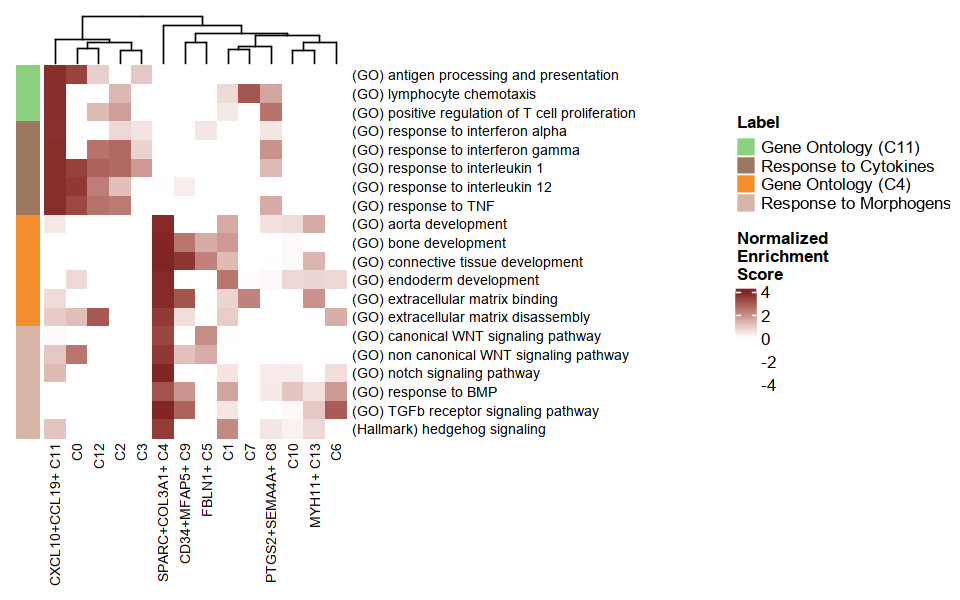

In [31]:
fig.size(5, 8)

ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 8))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))

h1 <- Heatmap(
    mat, 
    name = 'Normalized\nEnrichment\nScore', 
#     col = colorRamp2(c(min(mat), 0, max(mat)), c(muted('blue'), "white", muted("red"))),
    col = colorRamp2(c(min(mat), 0, max(mat)), c('white', "white", muted("red"))),
    column_names_rot = 90,
    left_annotation = rowAnnotation(
        df = data.frame(Label = X$Label),
#             show_legend = FALSE,
#         col = colors,
        col = palette_heatmap,
        show_annotation_name = FALSE
    ),
    cluster_rows = FALSE, 
#     use_raster = TRUE, raster_device = "CairoJPEG"
)

# draw(h1)
# draw(h1, annotation_legend_side = 'bottom')

# f7 <- grid.grabExpr(draw(h1, annotation_legend_side = 'top'))
f7 <- grid.grabExpr(draw(h1, padding = unit(c(1, 1, 1, 22), "mm"), heatmap_legend_side = 'right')) #bottom, left, top, right paddings
wrap_elements(f7)


# Panels

Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


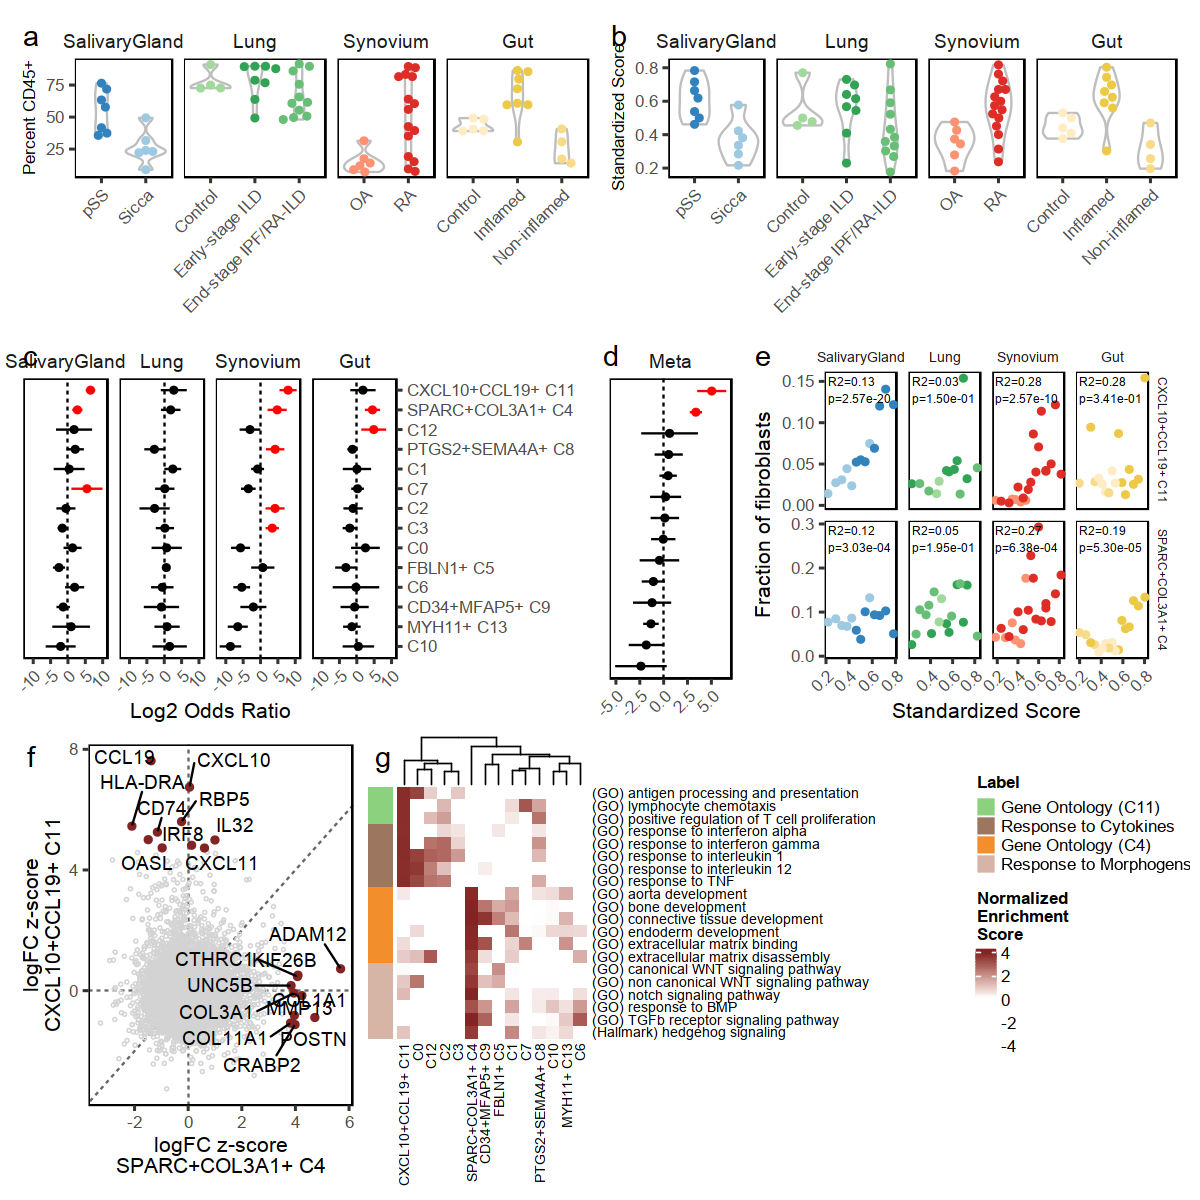

In [32]:
fig.size(10, 10)
main_figure <- (
    wrap_elements(full = f1) | wrap_elements(full = f2)
) / 
(
    (wrap_elements(full = f3) | wrap_elements(full = f4) | wrap_elements(full = f5)) + plot_layout(widths = c(1.2, .25, .9))
) / (
    (wrap_elements(full = f6) | wrap_elements(full = f7)) + plot_layout(widths = c(1, 2.5))
) + 
    plot_annotation(tag_levels = 'a') + 
    plot_layout(heights = c(1, 1.3, 1.5))

main_figure


In [33]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/Figure3.pdf', 
    plot = main_figure,
    units = 'in', device = 'pdf', 
    height = 10, width = 10,
    useDingbats = FALSE
)


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
